In [2]:
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer

In [3]:
df = pd.read_csv("/Users/sahil/Programs/projects/MSA/Datasets/IMDB Dataset.csv")

In [4]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

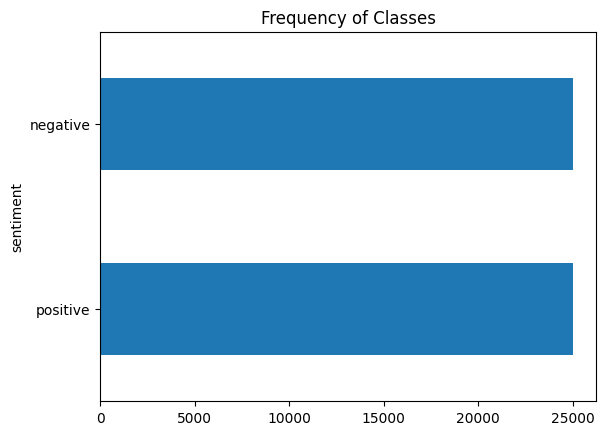

In [5]:
label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per review'}, xlabel='sentiment'>

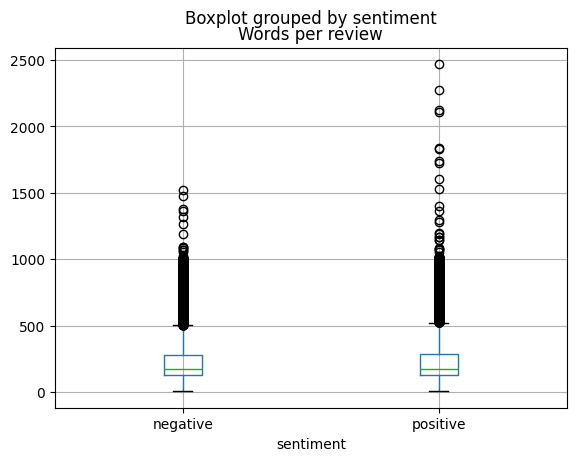

In [6]:
df['Words per review'] = df['review'].str.split().apply(len)
df.boxplot("Words per review", by="sentiment")

In [7]:
model_ckpt = "distilbert-base-uncased"  #ENGLISH english
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "We love to sleep! Winters are awesome!"
encoded_text = tokenizer(text)
print(encoded_text)
len(tokenizer.vocab),tokenizer.vocab_size, tokenizer.model_max_length

{'input_ids': [101, 2057, 2293, 2000, 3637, 999, 12214, 2024, 12476, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


(30522, 30522, 512)

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 3), (10000, 3), (5000, 3))

In [9]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 5000
    })
})

In [11]:
dataset['train']

Dataset({
    features: ['review', 'sentiment', 'Words per review'],
    num_rows: 35000
})

In [12]:
def tokenize(batch):
    # Tokenize text with padding and truncation
    temp = tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True)

    # Convert sentiment from strings ("positive"/"negative") to integers (1/0)
    temp['labels'] = [1 if sentiment == 'positive' else 0 for sentiment in batch['sentiment']]

    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2070, 2025, 1011, 2061, 1011, 27594, 2100, 27594, 2545, 3805, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2339, 2079, 2111, 1010, 2043, 2027, 2024, 4487, 21748, 25099, 2094, 2030, 5305, 2030, 6015, 2012, 1037, 2252, 1010, 3013, 2083, 1996, 2690, 1997, 1996, 10789, 3153, 2723, 2006, 2037, 2126, 2000, 1996, 5723, 1029, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2040, 1999, 2037, 2157, 2568, 2052, 5342, 2104, 1037, 2793, 2043, 2619, 7807, 2046, 2037, 2282, 1029, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2129, 2411, 2079, 2017, 7324, 2006, 1037, 7985, 1005, 1055, 2341, 1998, 2043, 2027, 2123, 1005, 1056, 3202, 3437, 1010, 2017, 2330, 1996, 2341, 1010, 3328, 1999, 1010, 11245, 1037, 2261, 7592, 1005, 1055, 1998, 2059, 2707, 2183, 2083, 2037, 4933, 1029, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2065, 2017, 2020, 2108, 9505, 2011, 2619, 2017, 2074, 3603, 2001, 1037, 13422, 1010, 2054, 2052, 2017, 2079, 1029, 5168, 13583, 2125, 1998, 5342, 2104, 1037,

In [14]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [16]:
sentiment_id = list({x['sentiment'] for x in dataset ['train']})
id2label = {id:label for id, label in enumerate(sentiment_id)}
label2id = {label:id for id, label in id2label.items()}
sentiment_id, id2label, label2id

(['positive', 'negative'],
 {0: 'positive', 1: 'negative'},
 {'positive': 0, 'negative': 1})

In [17]:
model= AutoModel.from_pretrained(model_ckpt)

In [18]:
model.config
model_two="bert-base-cased"

In [19]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
Num_labels = len(label2id)
device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
device

device(type='cpu')

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import TrainingArguments
batch_size=2
training_dir = "bert_base_training_dir"
training_args= TrainingArguments(output_dir = training_dir,
              overwrite_output_dir = True,
              num_train_epochs = 2,
              learning_rate = 2e-5,
              per_device_train_batch_size = batch_size,
              per_device_eval_batch_size = batch_size,
              weight_decay = 0.01,
              evaluation_strategy = 'epoch',
              disable_tqdm = False
    )

/Users/sahil/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer=tokenizer
)

NameError: name 'compute_metrics' is not defined

In [66]:
import wandb

# Replace your API key inside the quotes
wandb.login(key="40907ad1b0fee06461600d6cd5c0798707707d2e")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [67]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.model_save("MSA_bert_model")

In [53]:
path_to_model='/Users/sahil/Programs/projects/MSA/model'
tuned_model = AutoModelForSequenceClassification.from_pretrained(path_to_model)
tuned_tokenizer = AutoTokenizer.from_pretrained(path_to_model)


In [ ]:
text = "The movie was like sweet candy."
inputs=tuned_tokenizer(text=text)
inputs = tuned_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = tuned_model(**inputs)

logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)

predicted_label = torch.argmax(probabilities, dim=-1).item()
label_map = {0: "negative", 1: "positive"}  
print(f"Predicted Label: {label_map[predicted_label]} (Probability: {probabilities[0, predicted_label].item():.4f})")


Predicted Label: positive (Probability: 0.8825)


In [98]:
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score

test_dataloader = DataLoader(
    emotion_encoded['train'],
    batch_size=32,  # Increase this from 1
    shuffle=False
)


In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import numpy as np
from tqdm import tqdm  # For the progress bar
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Add this before your accuracy calculation
print("First batch structure:")
batch = next(iter(test_dataloader))
for key in batch:
    print(f"{key}: {type(batch[key])}")
    print(f"Shape/Length: {len(batch[key])}")

print("\nLabels structure:")
print(f"Type: {type(emotion_encoded['test'])}")
print(f"Shape/Length: {len(emotion_encoded['test'])}")
print(f"First few labels: {emotion_encoded['test'][:5]}")

First batch structure:
review: <class 'list'>
Shape/Length: 32
sentiment: <class 'list'>
Shape/Length: 32
Words per review: <class 'torch.Tensor'>
Shape/Length: 32
input_ids: <class 'list'>
Shape/Length: 512
token_type_ids: <class 'list'>
Shape/Length: 512
attention_mask: <class 'list'>
Shape/Length: 512
labels: <class 'torch.Tensor'>
Shape/Length: 32

Labels structure:
Type: <class 'datasets.arrow_dataset.Dataset'>
Shape/Length: 10000
First few labels: {'review': ["Good Movie, acting was terrific especially from Eriq Ebouaney(Lumumba)and very well directed.<br /><br />It also shows how Lumumba was cornered by the Belgians, U S A and United Nations and how they labelled him a `communist' to scare people as they did to all the Honest True African leaders like Nkrumah, Kenyatta, Nyerere and many others. It shows how western countries preach democracy while they have something else on the back of their minds. It is a story of injustice, struggle and brutality.<br /><br />It shows how Lumu

In [106]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, dataloader, device=None):  
    # Automatically choose the device if None
    device = device or ("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")

    # Make sure the model is on the correct device
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_true_labels = []
    
    # Using tqdm to track the progress during evaluation
    for batch in tqdm(dataloader, desc="Evaluating Accuracy", dynamic_ncols=True):
        # Convert lists to tensors and handle batch dimension
        input_ids = torch.stack([torch.tensor(item) for item in batch['input_ids']]).to(device)
        attention_mask = torch.stack([torch.tensor(item) for item in batch['attention_mask']]).to(device)
        token_type_ids = torch.stack([torch.tensor(item) for item in batch['token_type_ids']]).to(device)
        
        # Ensure labels are properly shaped
        if isinstance(batch['labels'], torch.Tensor):
            labels = batch['labels'].view(-1).to(device)  # Reshape to 1D
        else:
            labels = torch.tensor(batch['labels'], dtype=torch.long).view(-1).to(device)
        
        # Create inputs dictionary
        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            
            # Ensure predictions are properly shaped
            predictions = torch.argmax(logits, dim=-1)
            
            # Convert to numpy and append
            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_true_labels.extend(labels.cpu().numpy().tolist())
    
    accuracy = accuracy_score(all_true_labels, all_predictions)
    return accuracy

# Use it like this (you can optionally specify device if needed)
accuracy = calculate_accuracy(tuned_model, test_dataloader)  # Automatically detects device
print(f"Test Accuracy: {accuracy:.4f}")

/var/folders/37/x82lvgr524l4fd08t3g06rl40000gn/T/ipykernel_20874/1704487477.py:7: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = device or ("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
Evaluating Accuracy:   0%|          | 0/1094 [00:00<?, ?it/s]/var/folders/37/x82lvgr524l4fd08t3g06rl40000gn/T/ipykernel_20874/1704487477.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.stack([torch.tensor(item) for item in batch['input_ids']]).to(device)
/var/folders/37/x82lvgr524l4fd08t3g06rl40000gn/T/ipykernel_20874/1704487477.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.stack

KeyboardInterrupt: 

In [24]:
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def calculate_confusion_matrix(model, dataloader, device="cpu"):
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    for batch in tqdm(dataloader, desc="Calculating Confusion Matrix"):
        # Convert lists to tensors and handle batch dimension
        input_ids = torch.stack([torch.tensor(item) for item in batch['input_ids']]).to(device)
        attention_mask = torch.stack([torch.tensor(item) for item in batch['attention_mask']]).to(device)
        token_type_ids = torch.stack([torch.tensor(item) for item in batch['token_type_ids']]).to(device)
        
        # Ensure labels are properly shaped
        if isinstance(batch['labels'], torch.Tensor):
            labels = batch['labels'].view(-1).to(device)
        else:
            labels = torch.tensor(batch['labels'], dtype=torch.long).view(-1).to(device)
        
        # Create inputs dictionary
        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_true_labels.extend(labels.cpu().numpy().tolist())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Create labels for the classes
    labels = ['Negative', 'Positive']
    
    # Create and display confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    
    # Add text annotations with percentages
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / total * 100
            plt.text(j, i, f'\n{percentage:.1f}%', 
                    ha='center', va='center')
    
    # Calculate and print additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("\nDetailed Metrics:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    plt.show()
    return cm

# Use it like this:
confusion_mat = calculate_confusion_matrix(tuned_model, test_dataloader)

NameError: name 'tuned_model' is not defined

In [ ]:

# use pipeline for prediciton
from transformers import pipeline
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')
classifier([text, 'A very good day indeed', "We loved mth111", "I am feeling anxious"])